<a href="https://colab.research.google.com/github/ABehal2020/IBM-Graph-Neural-Network/blob/main/aditya_gnn_implementation_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install jupyter-book matplotlib numpy tensorflow pydot seaborn Pillow rdkit-pypi torch_geometric

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
import numpy as np
import warnings
import pandas as pd
import rdkit, rdkit.Chem, rdkit.Chem.rdDepictor, rdkit.Chem.Draw
import networkx as nx
import torch
import torch
import torch.nn as nn
import torch.nn.functional as F
# torch geometric
try: 
    import torch_geometric
except ModuleNotFoundError:
    # Installing torch geometric packages with specific CUDA+PyTorch version. 
    # See https://pytorch-geometric.readthedocs.io/en/latest/notes/installation.html for details 
    TORCH = torch.__version__.split('+')[0]
    CUDA = 'cu' + torch.version.cuda.replace('.','')

    !pip install torch-scatter     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
    !pip install torch-sparse      -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
    !pip install torch-cluster     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
    !pip install torch-spline-conv -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
    !pip install torch-geometric 
    import torch_geometric
from torch_geometric.nn import GCNConv
import torch.utils.data as data
import torch.optim as optim
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import dense_to_sparse, add_self_loops, to_scipy_sparse_matrix
from torch_geometric.data import Data
import torch.nn.functional as F
from six.moves import urllib

warnings.filterwarnings("ignore")
sns.set_context("notebook")
sns.set_style(
    "dark",
    {
        "xtick.bottom": True,
        "ytick.left": True,
        "xtick.color": "#666666",
        "ytick.color": "#666666",
        "axes.edgecolor": "#666666",
        "axes.linewidth": 0.8,
        "figure.dpi": 300,
    },
)
color_cycle = ["#1BBC9B", "#F06060", "#5C4B51", "#F3B562", "#6e5687"]
mpl.rcParams["axes.prop_cycle"] = mpl.cycler(color=color_cycle)

opener = urllib.request.build_opener()
opener.addheaders = [('User-agent', 'Mozilla/5.0')]
urllib.request.install_opener(opener)

soldata = pd.read_csv('https://dataverse.harvard.edu/api/access/datafile/3407241?format=original&gbrecs=true')
# had to rehost because dataverse isn't reliable
soldata = pd.read_csv(
    "https://github.com/whitead/dmol-book/raw/master/data/curated-solubility-dataset.csv"
)
np.random.seed(0)
my_elements = {6: "C", 8: "O", 1: "H"}

In [ ]:
def smiles2graph(sml):
    """Argument for the RD2NX function should be a valid SMILES sequence
    returns: the graph
    """
    m = rdkit.Chem.MolFromSmiles(sml)
    m = rdkit.Chem.AddHs(m)
    order_string = {
        rdkit.Chem.rdchem.BondType.SINGLE: 1,
        rdkit.Chem.rdchem.BondType.DOUBLE: 2,
        rdkit.Chem.rdchem.BondType.TRIPLE: 3,
        rdkit.Chem.rdchem.BondType.AROMATIC: 4,
    }
    N = len(list(m.GetAtoms()))
    nodes = np.zeros((N, len(my_elements)))
    lookup = list(my_elements.keys())
    for i in m.GetAtoms():
        nodes[i.GetIdx(), lookup.index(i.GetAtomicNum())] = 1

    adj = np.zeros((N, N, 5))
    for j in m.GetBonds():
        u = min(j.GetBeginAtomIdx(), j.GetEndAtomIdx())
        v = max(j.GetBeginAtomIdx(), j.GetEndAtomIdx())
        order = j.GetBondType()
        if order in order_string:
            order = order_string[order]
        else:
            raise Warning("Ignoring bond order" + order)
        adj[u, v, order] = 1
        adj[v, u, order] = 1
    return nodes, adj

In [ ]:
nodes, adj = smiles2graph("CO")
nodes

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.]])

In [ ]:
nodes, adj = smiles2graph("CO")
adj_mat = np.sum(adj, axis=-1) + np.eye(adj.shape[0])
adj_mat

array([[1., 1., 1., 1., 1., 0.],
       [1., 1., 0., 0., 0., 1.],
       [1., 0., 1., 0., 0., 0.],
       [1., 0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0., 1.]])

In [ ]:
degree = np.sum(adj_mat, axis=-1)
degree

array([5., 3., 2., 2., 2., 2.])

In [ ]:
print(nodes[0])
# note to divide by degree, make the input 1 / degree
new_nodes = np.einsum("i,ij,jk->ik", 1 / degree, adj_mat, nodes)
print(new_nodes[0])

[1. 0. 0.]
[0.2 0.2 0.6]


In [ ]:
class GCNLayer(torch.nn.Module):
    
    def __init__(self, c_in, c_out):
        super().__init__()
        self.projection = nn.Linear(c_in, c_out)

    def forward(self, node_feats, adj_matrix):
        """
        Inputs:
            node_feats - Tensor with node features of shape [batch_size, num_nodes, c_in]
            adj_matrix - Batch of adjacency matrices of the graph. If there is an edge from i to j, adj_matrix[b,i,j]=1 else 0.
                         Supports directed edges by non-symmetric matrices. Assumes to already have added the identity connections. 
                         Shape: [batch_size, num_nodes, num_nodes]
        """
        # Num neighbours = number of incoming edges
        num_neighbours = adj_matrix.sum(dim=-1, keepdims=True)
        node_feats = self.projection(node_feats)
        node_feats = torch.bmm(adj_matrix, node_feats)
        node_feats = node_feats / num_neighbours
        node_feats = F.relu(node_feats)
        
        return node_feats

In [ ]:
layer = GCNLayer(c_in=3, c_out=3)
layer.projection.weight.data = torch.Tensor([[1., 0., 0.], 
                                             [0., 1., 0.],
                                             [0., 0., 1.]])
'''
layer.projection.weight.data = torch.Tensor([[0.32973695, 0.9439781, 0.99448895],
                                             [0.48394036, 0.47628093, 0.976377],
                                             [0.11168528, -0.7981007, 0.14510608]])
'''

layer.projection.bias.data = torch.Tensor([0., 0., 0.])

nodes = torch.Tensor(nodes).reshape(1, 6, 3)
node_features = nodes
adj_mat = torch.Tensor(adj_mat).reshape(1, 6, 6)

print("Node features:\n", nodes)
print("\nAdjacency matrix:\n", adj_mat)
print(adj_mat.sum(dim=-1, keepdims=True))
print(adj_mat.shape)

with torch.no_grad():
        out_feats = layer(nodes, adj_mat)

print("Output features", out_feats)

Node features:
 tensor([[[1., 0., 0.],
         [0., 1., 0.],
         [0., 0., 1.],
         [0., 0., 1.],
         [0., 0., 1.],
         [0., 0., 1.]]])

Adjacency matrix:
 tensor([[[1., 1., 1., 1., 1., 0.],
         [1., 1., 0., 0., 0., 1.],
         [1., 0., 1., 0., 0., 0.],
         [1., 0., 0., 1., 0., 0.],
         [1., 0., 0., 0., 1., 0.],
         [0., 1., 0., 0., 0., 1.]]])
tensor([[[5.],
         [3.],
         [2.],
         [2.],
         [2.],
         [2.]]])
torch.Size([1, 6, 6])
Output features tensor([[[0.2000, 0.2000, 0.6000],
         [0.3333, 0.3333, 0.3333],
         [0.5000, 0.0000, 0.5000],
         [0.5000, 0.0000, 0.5000],
         [0.5000, 0.0000, 0.5000],
         [0.0000, 0.5000, 0.5000]]])


In [ ]:
degree_mat_manual = np.array([[5.],
         [3.],
         [2.],
         [2.],
         [2.],
         [2.]]).reshape(6,)
print(degree_mat_manual.shape)
weight_mat_manual = np.array([[1., 0., 0.], 
                                             [0., 1., 0.],
                                             [0., 0., 1.]])
# 6 x 3
node_features_manual = node_features.reshape(6, 3)
# 3 x 3
adj_mat_manual = adj_mat.reshape(6, 6)
# real case with 100 features
# N x 100 = nodes features
# N x N = adjacency matrix
# 100 x 100 = weight matrix
# N x N x N x 100 x 100 x 100

# second dimension of N nodes must be kept constant so when N differs 

# 1000 --> 20 x 20 for N = 20 with batch size = 100, 1000 molecules of size 20
# 1000 x 20 x 100 (100 features)
# 100 x 100 for weight matrix
# 20 x 20 x 20 x 100

# test case below
# H (6 x 3) x W^T (3 x 3) --> 6 x 3 resultant
temp1 = np.dot(node_features_manual, weight_mat_manual.T)
print(temp1)
# A (6 x 6) x H (6 x 3) x W^T (3 x 3) ---> 6 x 6 x 6 x 3 x 6 x 3 ---> 6 x 3 resultant
temp2 = np.dot(adj_mat_manual, temp1)
print(temp2)
for i in range(len(degree_mat_manual)):
  temp2[i] = temp2[i]/degree_mat_manual[i]
print(temp2)

(6,)
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]]
[[1. 1. 3.]
 [1. 1. 1.]
 [1. 0. 1.]
 [1. 0. 1.]
 [1. 0. 1.]
 [0. 1. 1.]]
[[0.2        0.2        0.6       ]
 [0.33333333 0.33333333 0.33333333]
 [0.5        0.         0.5       ]
 [0.5        0.         0.5       ]
 [0.5        0.         0.5       ]
 [0.         0.5        0.5       ]]


In [ ]:
node_features_manual = temp2
# H x W^T --> 6 x 3 resultant
temp1 = np.dot(node_features_manual, weight_mat_manual.T)
print(temp1)
# A x H x W^T ---> 6 x 6 x 6 x 3 ---> 6 x 3 resultant
temp2 = np.dot(adj_mat_manual, temp1)
print(temp2)
for i in range(len(degree_mat_manual)):
  temp2[i] = temp2[i]/degree_mat_manual[i]
print(temp2)

[[0.2        0.2        0.6       ]
 [0.33333333 0.33333333 0.33333333]
 [0.5        0.         0.5       ]
 [0.5        0.         0.5       ]
 [0.5        0.         0.5       ]
 [0.         0.5        0.5       ]]
[[2.03333333 0.53333333 2.43333333]
 [0.53333333 1.03333333 1.43333333]
 [0.7        0.2        1.1       ]
 [0.7        0.2        1.1       ]
 [0.7        0.2        1.1       ]
 [0.33333333 0.83333333 0.83333333]]
[[0.40666667 0.10666667 0.48666667]
 [0.17777778 0.34444444 0.47777778]
 [0.35       0.1        0.55      ]
 [0.35       0.1        0.55      ]
 [0.35       0.1        0.55      ]
 [0.16666667 0.41666667 0.41666667]]


In [ ]:
out_feats = nodes
for i in range(2):
  with torch.no_grad():
          out_feats = layer(out_feats, adj_mat)
        
print("Output features", out_feats)

Output features tensor([[[0.4067, 0.1067, 0.4867],
         [0.1778, 0.3444, 0.4778],
         [0.3500, 0.1000, 0.5500],
         [0.3500, 0.1000, 0.5500],
         [0.3500, 0.1000, 0.5500],
         [0.1667, 0.4167, 0.4167]]])


In [ ]:
class GRLayer(torch.nn.Module):

    def __init__(self, **kwargs):
        super(GRLayer, self).__init__(**kwargs)

    def forward(self, node_feats):
        # print(node_feats.shape)
        reduction = torch.mean(torch.Tensor(node_feats), 1, True)
        return reduction

In [ ]:
def gen_smiles2graph(sml):
    """Argument for the RD2NX function should be a valid SMILES sequence
    returns: the graph
    """
    m = rdkit.Chem.MolFromSmiles(sml)
    m = rdkit.Chem.AddHs(m)
    order_string = {
        rdkit.Chem.rdchem.BondType.SINGLE: 1,
        rdkit.Chem.rdchem.BondType.DOUBLE: 2,
        rdkit.Chem.rdchem.BondType.TRIPLE: 3,
        rdkit.Chem.rdchem.BondType.AROMATIC: 4,
    }
    N = len(list(m.GetAtoms()))
    nodes = np.zeros((N, 100))
    for i in m.GetAtoms():
        nodes[i.GetIdx(), i.GetAtomicNum()] = 1

    adj = np.zeros((N, N))
    for j in m.GetBonds():
        u = min(j.GetBeginAtomIdx(), j.GetEndAtomIdx())
        v = max(j.GetBeginAtomIdx(), j.GetEndAtomIdx())
        order = j.GetBondType()
        if order in order_string:
            order = order_string[order]
        else:
            raise Warning("Ignoring bond order" + order)
        adj[u, v] = 1
        adj[v, u] = 1
    adj += np.eye(N)
    return nodes, adj

In [ ]:
nodes, adj = gen_smiles2graph("CO")
# model((nodes[np.newaxis, ...], adj_mat[np.newaxis, ...]))
ninput = torch.Tensor(nodes).reshape(1, 6, 100)
ainput = torch.Tensor(adj_mat).reshape(1, 6, 6)
# print(ninput)
# print(ninput.shape)
# print(ainput)
# print(ainput.shape)
# GCN block
layer = GCNLayer(c_in=100, c_out=100)
x = layer(ninput, ainput)
x = layer(x, ainput)
x = layer(x, ainput)
x = layer(x, ainput)
# reduce to graph features
# averaging all the nodes (reduction over the columns) --> you get a vector of all the averaged node features
print(x.shape)
x = GRLayer()(x)
print(x.shape)
# standard layers (the readout)
layer1 = nn.Linear(in_features=100, out_features=16)
layer2 = nn.Linear(in_features=16, out_features=1)
x = layer1(x)
print(x.shape)
x = nn.functional.tanh(x)
print(x.shape)
x = layer2(x)
print(x.shape)
print(x)
# keras code - equivalent in PyTorch?
# model = tf.keras.Model(inputs=(ninput, ainput), outputs=x)

torch.Size([1, 6, 100])
torch.Size([1, 1, 100])
torch.Size([1, 1, 16])
torch.Size([1, 1, 16])
torch.Size([1, 1, 1])
tensor([[[-0.1698]]], grad_fn=<AddBackward0>)


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


In [ ]:
'''
def example():
    for i in range(len(soldata)):
        graph = gen_smiles2graph(soldata.SMILES[i])
        sol = soldata.Solubility[i]
        yield graph, sol

data = tf.data.Dataset.from_generator(
    example,
    output_types=((tf.float32, tf.float32), tf.float32),
    output_shapes=(
        (tf.TensorShape([None, 100]), tf.TensorShape([None, None])),
        tf.TensorShape([]),
    ),
)
'''

# PyTorch equivalent of tf code above using generator?

graph = []
sol = []
for i in range(len(soldata)):
    graph.append(gen_smiles2graph(soldata.SMILES[i]))
    sol.append(soldata.Solubility[i])

In [ ]:
# print(graph[0])
# print(sol[0])
# print(type(graph))
# print(type(sol))

class CustomDataset(data.Dataset):
    def __init__(self, graphAll, solAll, transform=None, target_transform=None):
        self.graphInstances = graphAll
        self.solInstances = solAll
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.graphInstances)

    def __getitem__(self, idx):
        graphInstance = self.graphInstances[idx]
        solInstance = self.solInstances[idx]
        if self.transform:
            graphInstance = self.transform(graphInstance)
        if self.target_transform:
            solInstance = self.target_transform(solInstance)
        return graphInstance, solInstance

In [ ]:
import multiprocessing

cores = multiprocessing.cpu_count() # Count the number of cores in a computer
cores

2

In [ ]:
dataset = CustomDataset(graphAll=graph, solAll=sol)
dataloader = data.DataLoader(dataset, batch_size=1,
                        shuffle=True, num_workers=cores)
# print(len(dataloader))
# print(type(dataloader))
test_data, val_data, train_data = data.random_split(dataloader, [200, 200, len(dataloader) - 400], generator=torch.Generator().manual_seed(42))

test_data_loader = data.DataLoader(test_data, batch_size=1, shuffle=True, num_workers=cores)
val_data_loader = data.DataLoader(val_data, batch_size=1, shuffle=True, num_workers=cores)
train_data_loader = data.DataLoader(train_data, batch_size=1, shuffle=True, num_workers=cores)
# print(test_data)
# print(val_data)
# print(train_data)
# print(train_data.__getitem__(0))

In [ ]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.gcn_layer = GCNLayer(c_in=100, c_out=100)
        self.gr_layer = GRLayer()
        self.linear_layer1 = nn.Linear(100, 16)
        self.nonlinear_activation_fx = nn.Tanh()
        self.linear_layer2 = nn.Linear(16, 1)
        '''
        self.gcn_linear_relu_stack = nn.Sequential(
            GCNLayer(c_in=100, c_out=100),
            GCNLayer(c_in=100, c_out=100),
            GCNLayer(c_in=100, c_out=100),
            GCNLayer(c_in=100, c_out=100),
            nn.Linear(100, 16),
            nn.Tanh(),
            nn.Linear(16, 1),
        )
        '''
    
    def forward(self, ninput, ainput):
        x = self.gcn_layer(ninput, ainput)
        x = self.gcn_layer(x, ainput)
        x = self.gcn_layer(x, ainput)
        x = self.gcn_layer(x, ainput)
        x = self.gr_layer(x)
        x = self.linear_layer1(x)
        x = self.nonlinear_activation_fx(x)
        x = self.linear_layer2(x)
        return x
        '''
        solubility = self.gcn_linear_relu_stack(ninput, ainput)
        return solubility
        '''

model = NeuralNetwork()

In [ ]:
def train_loop(dataloader, dataloader2, model, loss_fn, optimizer):
    # print("before size")
    size = len(dataloader.dataset)
    # print("after size")
    # print(size)
    loss_batch = []
    for batch, (X, y) in enumerate(dataloader.dataset):
    # for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        # print(len(X))
        # print(X[0].shape)
        # print(X[1].shape)
        ninput = X[0].float()
        # print(ninput.shape)
        ainput = X[1].float()
        # print(ainput.shape)
        # print(ainput.sum(dim=-1, keepdims=True))
        pred = model(ninput, ainput)
        # print(pred.shape)
        yReshaped = torch.Tensor([y]).reshape(1, 1, 1)
        # print(yReshaped.shape)
        # print("Prediction: %s, Actual value %s", pred, yReshaped)
        loss = loss_fn(pred, yReshaped)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss_batch.append(loss.item())

    loss_epoch = np.average(loss_batch)

    print("Training loss: ", loss_epoch)

    val_loss_batch = []

    with torch.no_grad():
        for batch, (X, y) in enumerate(dataloader2.dataset):
        # for batch, (X, y) in enumerate(dataloader2):
            ninput = X[0].float()
            ainput = X[1].float()
            pred = model(ninput, ainput)
            yReshaped = torch.Tensor([y]).reshape(1, 1, 1)
            loss = loss_fn(pred, yReshaped)
      
            val_loss_batch.append(loss.item())
    
    val_loss_epoch = np.average(val_loss_batch)

    print("Validation loss: ", val_loss_epoch)

    return loss_epoch, val_loss_epoch

def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader.dataset:
        # for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    # print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [ ]:
learning_rate = 1e-3
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
train_loss = []
val_loss = []
loss_epochs = []
val_loss_epochs = []

epochs = 20
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    # we need to check to see if train_data and val_data is being shuffled before each epoch along with playing around with different initializations (and can do multiple reruns)
    # we can also try SGD for a few epochs (5) before doing Adam or maybe try SGD for all 20 epochs
    # we can run several jupyter notebooks in parallel
    train_loss_epoch_value, val_loss_epoch_value = train_loop(train_data_loader.dataset, val_data_loader.dataset, model, loss_fn, optimizer)
    train_loss.append(train_loss_epoch_value)
    val_loss.append(val_loss_epoch_value)
    # test_loop(test_data, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
Training loss:  5.654659854809113
Validation loss:  5.611922339935841
Epoch 2
-------------------------------
Training loss:  5.6290820141852915
Validation loss:  5.621657910855296
Epoch 3
-------------------------------
Training loss:  5.632663964004846
Validation loss:  5.608591241965499
Epoch 4
-------------------------------
Training loss:  5.631504467256939
Validation loss:  5.607733830244294
Epoch 5
-------------------------------
Training loss:  5.6282572876684345
Validation loss:  5.634597700786367
Epoch 6
-------------------------------
Training loss:  5.626533399655708
Validation loss:  5.6085097215386055
Epoch 7
-------------------------------
Training loss:  5.626005397194324
Validation loss:  5.610077065095863
Epoch 8
-------------------------------
Training loss:  5.6317207551215605
Validation loss:  5.607664489079248
Epoch 9
-------------------------------
Training loss:  5.635157089619353
Validation loss:  5.619756302616692
Epoch 

In [ ]:
# train_loss = [4.226139596777066, 3.004239772329186, 2.572852132083354, 2.4141540110657216, 2.3216654043936646, 2.1875368104018067, 2.1429045711136068, 2.069950588210219, 1.9942445817747199, 1.9191229061224768, 1.8690842514004369, 1.7871576600868404, 1.7476929143898259, 1.7090401340630716, 1.6644819780875477, 1.6327650274479517, 1.5917086882318254, 1.5811287509559409, 1.554251340270101, 1.5298286575051994]
# print(len(train_loss))

In [ ]:
print(len(train_loss))
print(len(val_loss))

20
20


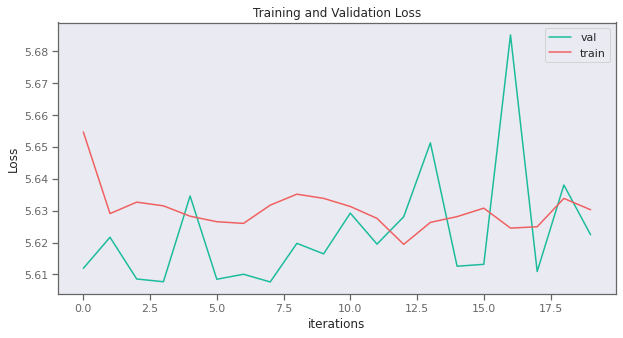

In [ ]:
train_loss = torch.Tensor(train_loss)
val_loss = torch.Tensor(val_loss)

plt.figure(figsize=(10,5))
plt.title("Training and Validation Loss")
plt.plot(val_loss,label="val")
plt.plot(train_loss,label="train")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()